In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.getcwd()

'/scratch/ziqi.kang/NIPMAP_updated/macro_micro_niches/ISS_analysis/notebooks'

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import json
import qpsolvers
import warnings
warnings.filterwarnings('ignore')

from matplotlib.legend import Legend
from skimage import io
from pathlib import Path
from sklearn.decomposition import PCA
from src.utils.archetypes import ArchetypalAnalysis
from src.CellAbundance import CellAbundance, generate_abundance_matrix, join_abundance_matrices
from src.utils.visualization import radius_pc_heatmap, plot_cells_positions, plot_cev_radius, plot_stacked_var_radius, radius_pc_all_variance, radius_pc_variance_contourf, plot_cells_markers_tmens
from src.utils.visualization import plot_scatter_pca, plot_3Dscatter_pca, archetypes_bar_plot, archetype_simple_plot, plot_cells_positions, plot_all_tumors_cell_positions, get_segmentation_matrix
from src.utils.equations import arch2color, alfa2rgb, scale, color_mapper
from src.utils.equations import compute_cells_niches_weights, get_niches_cell_abund
from functools import partial

## Load and save the workspace

In [ ]:
import dill                            
filepath = './NIPMAP_working_session.pkl'

In [ ]:
dill.load_session(filepath) # Load the session

In [ ]:
dill.dump_session(filepath) # Save the session

## Radius Analysis

5.0
6.0
8.0
10.0
12.0
15.0
18.0
22.0
28.0
34.0
42.0
53.0
65.0
81.0
100.0


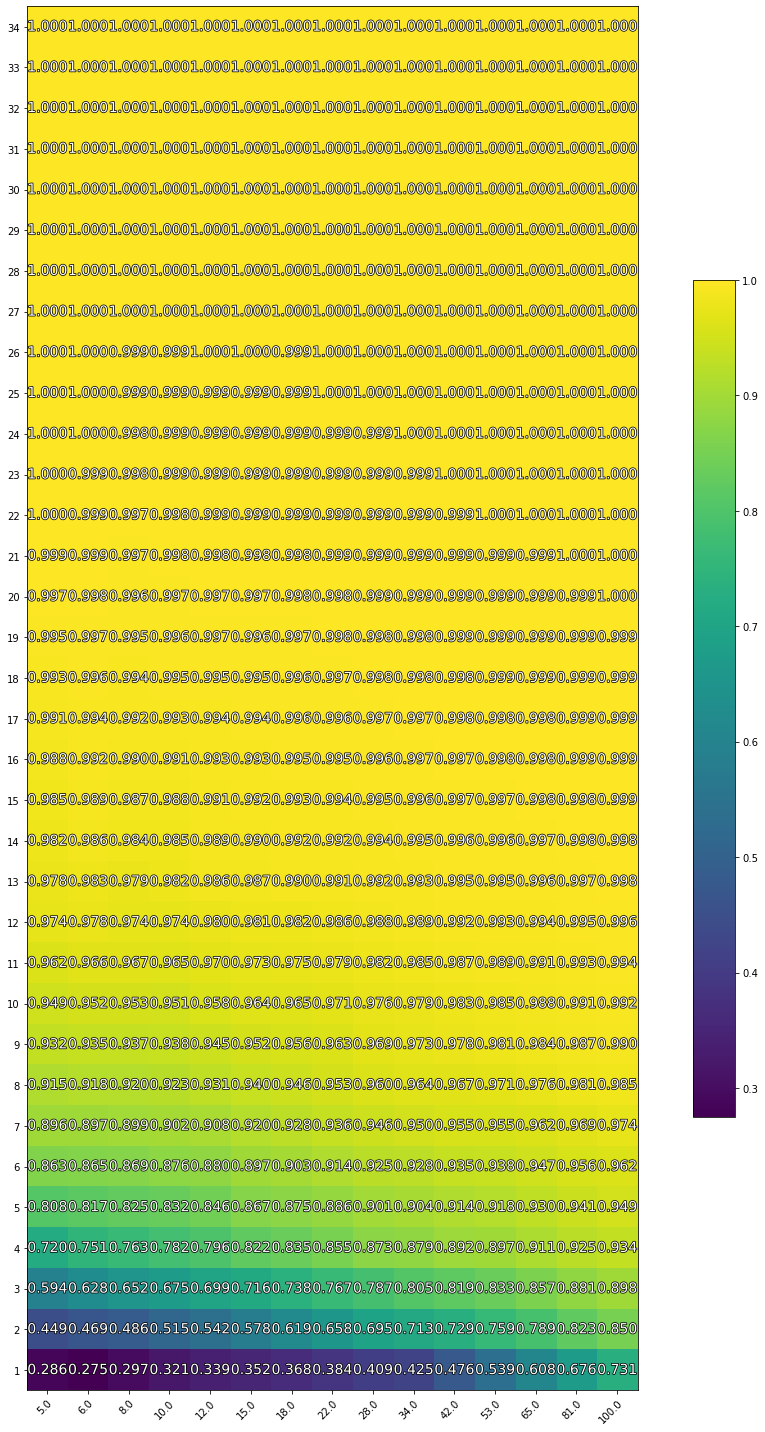

In [6]:
ROOT_DATA_PATH = "../data/"

CELL_TYPES = ['secretory', 'epithelial', 'proliferating smooth muscle', 'lymphatic endothelial', 'arterial', 
'mesenchymal', 'ciliated epithelial', 'neuronal', 'pericyte', 'ASM', 
'fibroblast', 'megakaryocyte', 'proximal progenitor', 'endothelial', 'neuroendocrine', 
'chondroblast', 'airway smooth muscle', 'Dendritic', 'macrophage', 'myeloid', 
'mesothelial', 'monocyte', 'capillary', 'ILC3', 'B-cell', 
'erythrocyte', 'myeloid progenitor', 'dendritic', 'mast/basophil', 'venous', 
'neutrophil', 'ILC2', 'lymphoid progenitor', 'natural killer']

full_patient_ids = [1]

N_SITE = 5000
radius = np.linspace(np.log(5), np.log(100), num=15)
radius = np.rint(np.power(np.e, radius).astype(float))
METHOD = 'gaussian'
x_size = 6500
y_size = 6500

expl_var_ratio_gauss = {}
for r in radius:
    print(r)
    gaussian_count_list = generate_abundance_matrix(CELL_TYPES, full_patient_ids, N_SITE, r, method=METHOD, snr=3, image_x_size = x_size, image_y_size = y_size, root=ROOT_DATA_PATH)
    sites, patient_ids,s_ids, _ = join_abundance_matrices(gaussian_count_list)
    pca = PCA()
    pc = pca.fit_transform(sites)
    expl_var_ratio_gauss[r] = np.cumsum(pca.explained_variance_ratio_)
radius_pc_heatmap(expl_var_ratio_gauss)

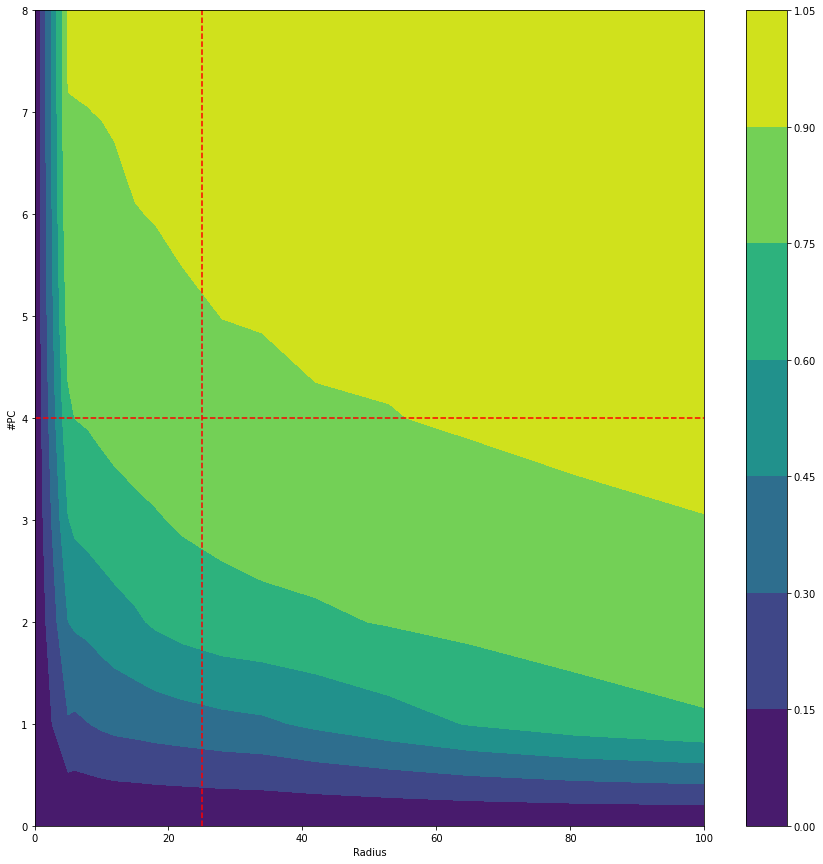

In [8]:
radius_pc_all_variance(expl_var_ratio_gauss,radius_lim=25,nPC_lim=4,cells_number=35, 
                       save_fig=True, path_fig="../output/radius_plot.pdf")

## Archetypal Analysis

Input all parameters needed for the analysis. 

In [10]:
ROOT_DATA_PATH = "../data/"

CELL_TYPES = ['secretory', 'epithelial', 'proliferating smooth muscle', 'lymphatic endothelial', 'arterial', 
'mesenchymal', 'ciliated epithelial', 'neuronal', 'pericyte', 'ASM', 
'fibroblast', 'megakaryocyte', 'proximal progenitor', 'endothelial', 'neuroendocrine', 
'chondroblast', 'airway smooth muscle', 'Dendritic', 'macrophage', 'myeloid', 
'mesothelial', 'monocyte', 'capillary', 'ILC3', 'B-cell', 
'erythrocyte', 'myeloid progenitor', 'dendritic', 'mast/basophil', 'venous', 
'neutrophil', 'ILC2', 'lymphoid progenitor', 'natural killer']

patient_id = [1]

N_SITE = 20000 
NBNICHES = 5
RADIUS = 25
METHOD = "gaussian"
x_size = 6500
y_size = 6500

color_range = [[255, 0, 223],
 [0, 0, 255],
 [70, 203, 236],
 [255, 0, 0],
 [0, 153, 51],
 [225, 255, 0],
 [0, 0, 0]]
 
color_list = color_range[0:NBNICHES-1]
color_list.append([0,0,0])

SAVE_DATA_PATH = Path("{}/niche{}_radius{}_patientid{}/".format(ROOT_DATA_PATH,NBNICHES,RADIUS,patient_id))
SAVE_DATA_PATH.mkdir(parents=True, exist_ok=True)

Generate cell abundance matrix based on sites. Fit archetype and visualize it. 

0.78% Total Exp. Var.


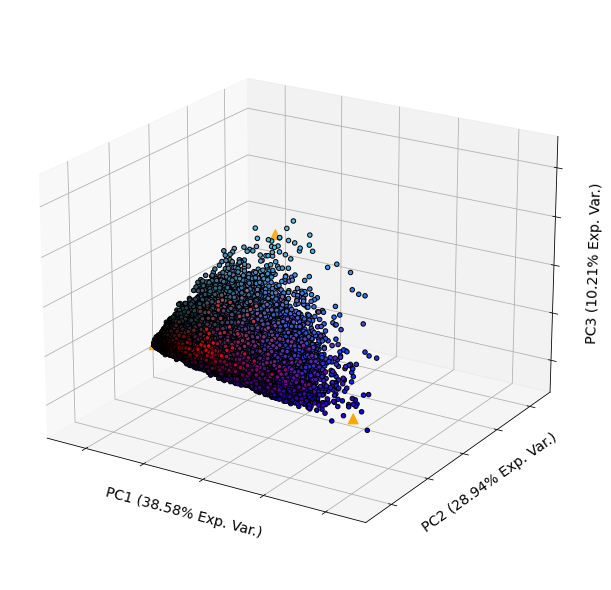

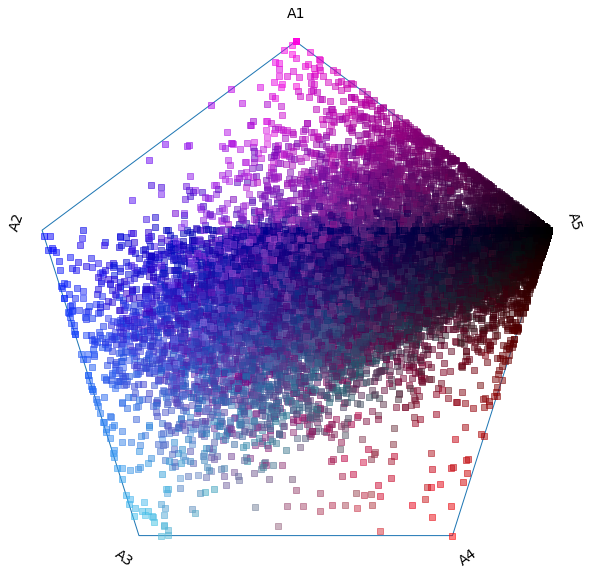

In [13]:
CellAb_list = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD, snr=3, image_x_size = x_size, image_y_size = y_size, center_sites_cells=False, root=ROOT_DATA_PATH)
sites, patients_ids, sites_ids, _ = join_abundance_matrices(CellAb_list)

CellAb_df = pd.DataFrame() 
for ca in CellAb_list:
    abundance_df = pd.DataFrame(ca.abundance_matrix,columns = CELL_TYPES)
    abundance_df['site_id'] = np.arange(len(abundance_df))
    abundance_df['patient_id'] = ca.patient_id
    CellAb_df = CellAb_df.append(abundance_df)
CellAb_df = CellAb_df.reset_index()

pca_obj = PCA()
pc_proj = pca_obj.fit_transform(sites)


AA = ArchetypalAnalysis(n_archetypes = NBNICHES, 
    tolerance = 0.001, 
    max_iter = 200, 
    random_state = 0, 
    C = 0.0001, 
    initialize = 'random', 
    redundancy_try = 30)

AA.fit_transform(pc_proj[:,:NBNICHES-1])


def round2one(v):
    return v if v <= 1.0 else 1.0
color_map = np.array(color_list).T
sites_archetype = [np.array([round2one(x) for x in color_mapper(color_map, c)/255]) for c in AA.alfa.T]
p = np.array(sites_archetype)
p[p > 1]

plot_3Dscatter_pca(pc_proj, pca_obj.explained_variance_ratio_, labels=sites_archetype, archetypes=AA.archetypes)

un, counts = np.unique(np.argmax(AA.alfa.T, axis=1), return_counts=True)
bb_counts = dict(zip(un+1, (counts/N_SITE)*100))
bb_counts

AA.plot_simplex(AA.alfa, plot_args={'c': sites_archetype})

## Visualization

Plot the cell density barplot for all niches, in order to explore biological meanings. 

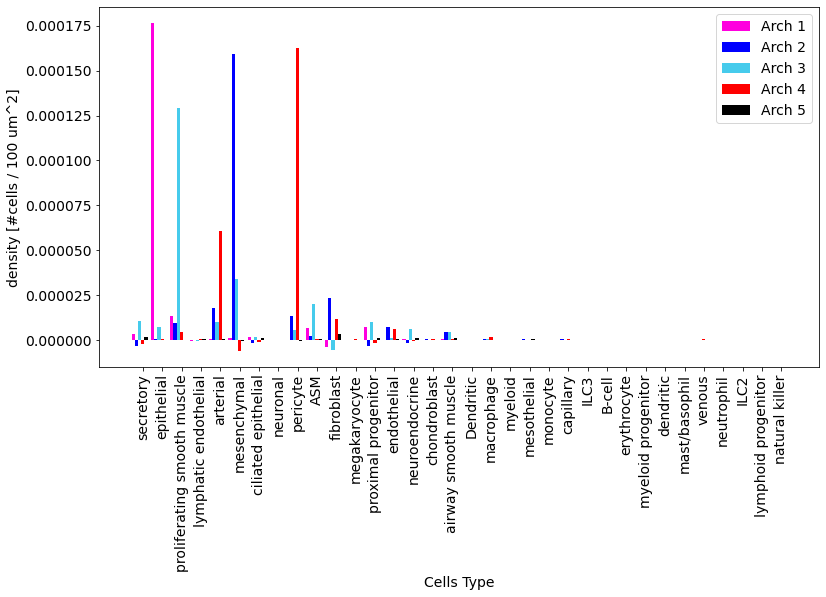

In [15]:
n_comp = NBNICHES-1
res = np.dot(AA.archetypes.T, pca_obj.components_[:n_comp,:])+np.mean(sites, axis=0)

pcres = AA.archetypes.T
niche_pcabundance = pd.DataFrame(pcres)
#niche_pcabundance.to_csv("{}/niche_pcabundance.csv".format(SAVE_DATA_PATH))

niche_cellabundance = pd.DataFrame(res, columns=CELL_TYPES)
#niche_cellabundance.to_csv("{}/niche_cellbundance.csv".format(SAVE_DATA_PATH))
    # archetype_colors = [[1., 0., 0.], [0. , 0.6, 0.2], [0., 0., 1.], [1.0, 1.0, 0.], [1.0, 0, 1.0]]
archetype_colors = np.array(color_list)/255

archetypes_bar_plot(res, CELL_TYPES, archetype_colors, y_axis='density', radius=RADIUS, path_fig="{}/arche_barplot.svg".format(SAVE_DATA_PATH)) # 

Plot the original tissue and the tissue segmented according to the nices. 

<module 'matplotlib.pyplot' from '/scratch/ziqi.kang/miniconda3/envs/python/lib/python3.10/site-packages/matplotlib/pyplot.py'>

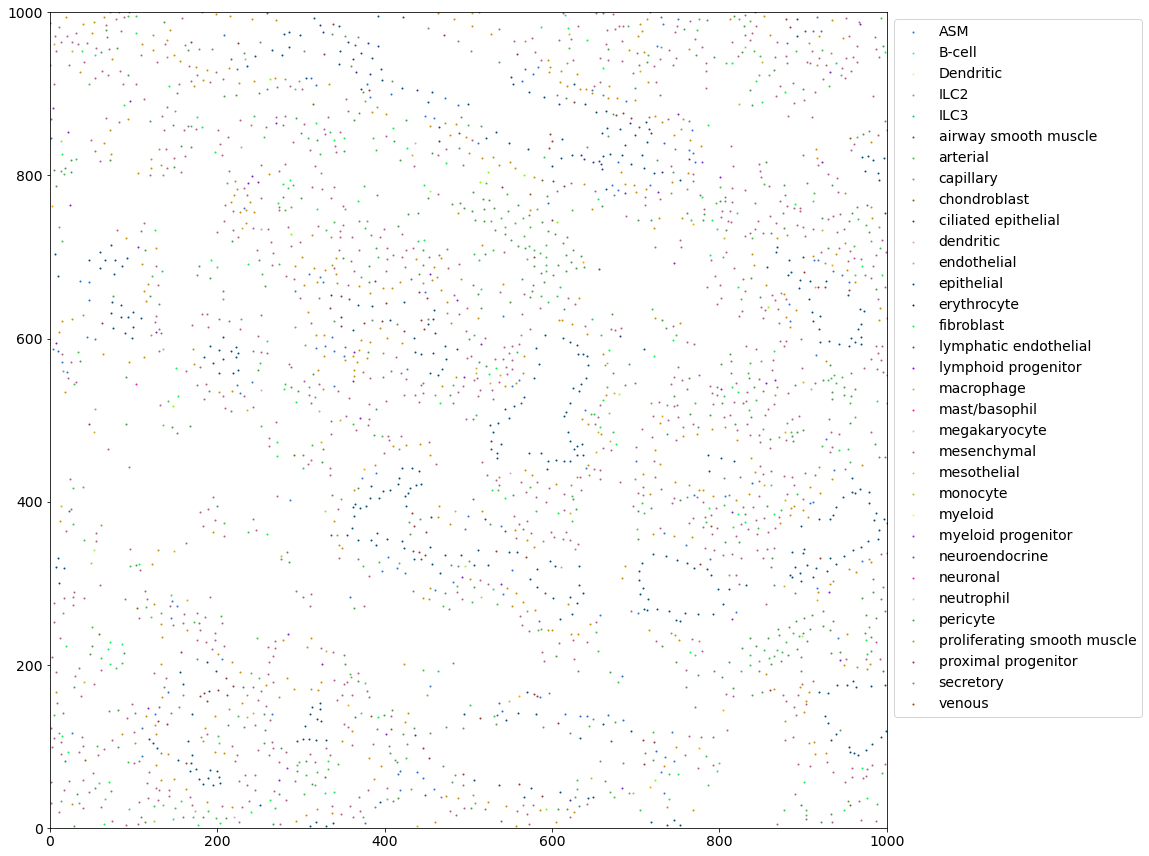

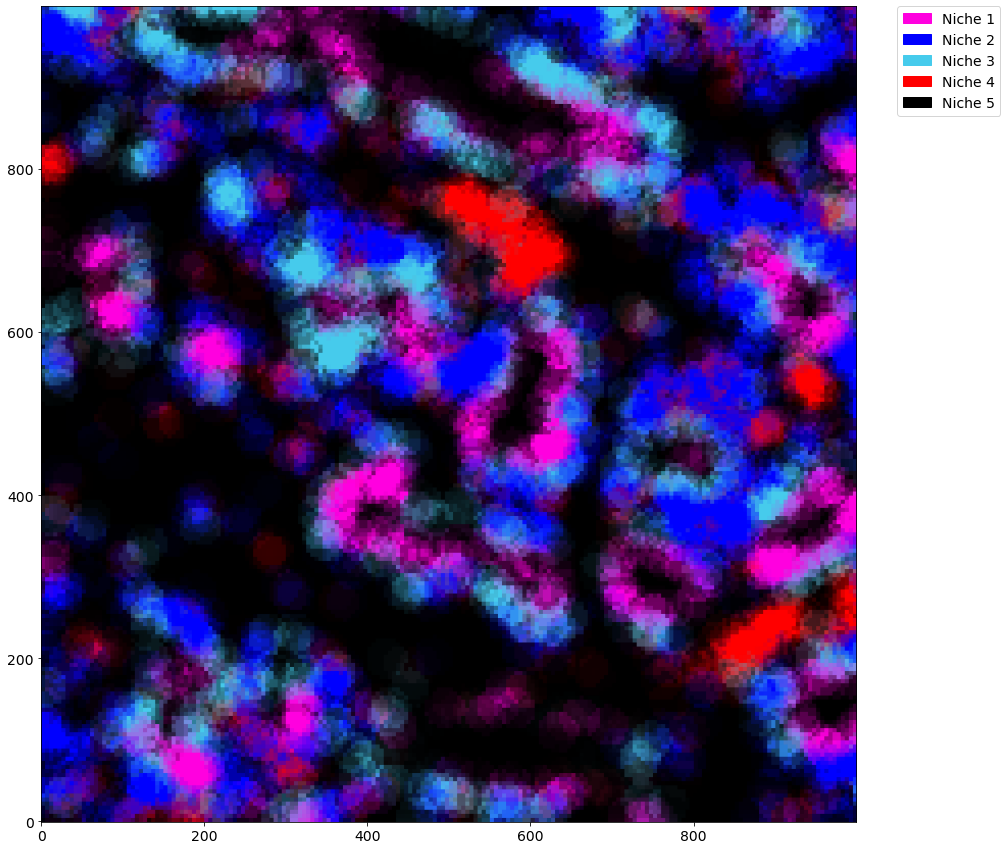

In [26]:
h = 1000
w = 1000
GRANULARITY = 5 # controls the resolution of niche segmentation. 
cell_data = pd.read_csv("{}/patient{}_cell_positions.csv".format(ROOT_DATA_PATH, 1))

colors = ['#629563', '#044E75', '#CA8F04', '#645D0D','#43BC52', 
'#B25E89', '#2E3790', '#F118BE','#50974E', '#3273D6', 
'#0AF24B', '#A3F159','#933835', '#CEB134', '#226BCF', 
'#856218','#831CCB','#EEE8AA', '#FFA500', '#FFFF00', 
'#7CFC00', '#9ACD32', '#32CD32', '#20B2AA','#00FFFF',
'#191970', '#8A2BE2','#DDA0DD','#FF1493','#8B4513',
'#B0C4DE','#CD853F','#9400D3','#0000FF'] # specify the colors for original figure, becasue too many cell types

plot_cells_positions(cell_data, CELL_TYPES, segment_image=False, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = colors, h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA, to_plot = 'all', path_fig="{}/Origin_fig_size{}*{}.svg".format(SAVE_DATA_PATH,h,w))

plot_cells_positions(cell_data, CELL_TYPES, segment_image=True, counting_type='gaussian',
                            segmentation_type='smooth', color_vector = color_list, h=h, w=w, granularity=GRANULARITY, radius=RADIUS,
                            pca_obj=pca_obj, AA_obj=AA, to_plot = 'None', path_fig="{}/Niche_segment_size{}*{}.svg".format(SAVE_DATA_PATH,h,w))

Plot interested markers in the segmented tissue. 

True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(13827, 6)
ok


<module 'matplotlib.pyplot' from '/scratch/ziqi.kang/miniconda3/envs/python/lib/python3.10/site-packages/matplotlib/pyplot.py'>

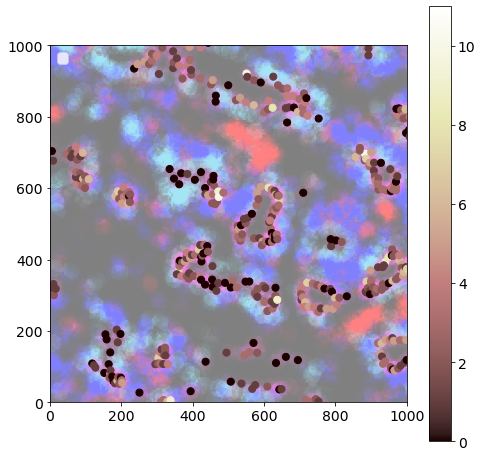

In [37]:
patientID = 1
GRANULARITY = 5
CELLT="epithelial"
Marker = "TPPP3"
symb = []

plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", h = 1000,w = 1000, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+".svg",
                        intOutQuant=0.01)

True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(8064, 6)
ok


<module 'matplotlib.pyplot' from '/scratch/ziqi.kang/miniconda3/envs/python/lib/python3.10/site-packages/matplotlib/pyplot.py'>

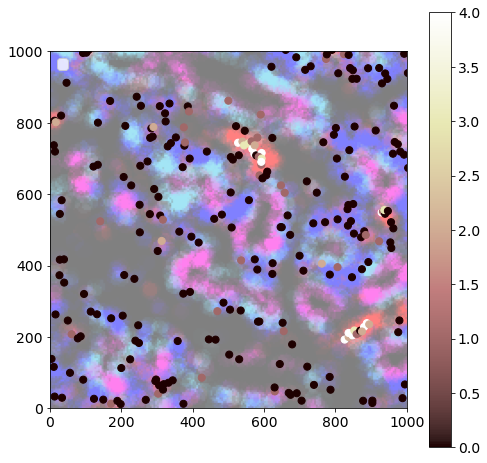

In [38]:
patientID = 1
GRANULARITY = 5
CELLT="arterial"
Marker = "JAG1"
symb = []

plot_cells_markers_tmens(patient_id=patientID,cell_types=CELL_TYPES,path_data=ROOT_DATA_PATH,
                         data_markers_path="{}/cellData_{}.csv".format(ROOT_DATA_PATH, patientID),
                         cell_type=CELLT, marker=Marker, symbols=symb,
                         segment_image = True, segmentation_type="smooth",
                         counting_type = "gaussian", h = 1000,w = 1000, granularity=GRANULARITY,radius = 25,
                         pca_obj = pca_obj,AA_obj = AA,
                         to_plot=[], path_fig = "../output/patient"+str(patientID)+"_tmens_"+CELLT+"_"+Marker+".svg",
                        intOutQuant=0.01)

## Save data

In [ ]:
# save the archetypal analysis result

dict_pca = {"PC_proj":pc_proj.tolist(),"components":pca_obj.components_.tolist(),"expl_variance":pca_obj.explained_variance_.tolist(), "expl_var_ratio":pca_obj.explained_variance_ratio_.tolist(),"mean":pca_obj.mean_.tolist()}
dict_AA = {"archs_coord": AA.archetypes.tolist(), "alfas": AA.alfa.tolist()}
PCA_json = json.dumps(dict_pca, indent=4)
AA_json = json.dumps(dict_AA, indent=4)

with open("{}/pca_sites.json".format(SAVE_DATA_PATH), "w") as outfile:
    outfile.write(PCA_json)
        
with open("{}/AA_sites.json".format(SAVE_DATA_PATH),"w") as outfile2:
    outfile2.write(AA_json)

# generate sites centered on cells 

CellAbCC_list = generate_abundance_matrix(CELL_TYPES, patient_id, N_SITE, RADIUS, method=METHOD, snr=3, center_sites_cells=True, root=ROOT_DATA_PATH)
sitesCC, patients_ids2, sites_ids2, _ = join_abundance_matrices(CellAbCC_list)
NichesProf = get_niches_cell_abund(sitesCellAb=sites, pcaSites=pca_obj, ArchObj=AA, nComp=NBNICHES-1)
sites_alfa = compute_cells_niches_weights(niches=NichesProf,cellsSites=sitesCC,nbNiches=NBNICHES)

sites_archs = pd.DataFrame(sites_alfa)
sites_archs['patient_id'] = patients_ids2
sites_archs["site_id"] = sites_ids2[:,0]
sites_archs["cell_type_site"] = sites_ids2[:,1]
sites_archs["TOT_cell_dens"]= sitesCC.sum(axis=1)

CellAbCC_df = pd.DataFrame(columns=[])
for ca in CellAbCC_list:
    df_ca = ca.get_site_cell_id_df()
    df_ca['patient_id'] = np.repeat(int(ca.patient_id), df_ca.shape[0], axis=0)
    # CellAbCC_df = pd.concat([CellAbCC_df, df_ca], axis=1)
    CellAbCC_df = CellAbCC_df.append(df_ca)
CellAbCC_df = CellAbCC_df.reset_index(drop = True)

# save the result. 

dict_caSites = {"cellAbSites": CellAb_df.to_dict()}
dict_caSitesCC = {"cells_niches": sites_archs.to_dict(),"cellAb_sitesCC": CellAbCC_df.to_dict()}

caSites_json = json.dumps(dict_caSites,indent=4)
cellsNiches_json = json.dumps(dict_caSitesCC,indent=4)

with open("{}/ca_sites.json".format(SAVE_DATA_PATH),"w") as outfile3:
    outfile3.write(caSites_json)      
with open("{}/cells_niches.json".format(SAVE_DATA_PATH),"w") as outfile4:
    outfile4.write(cellsNiches_json)